# 05 – Discretization and Binning
     Transforming Continuous Variables into Meaningful Categories


## Objective

This notebook provides a systematic treatment of discretization and binning, covering:

- Why and when to discretize continuous variables
- Equal-width vs equal-frequency binning
- Business-driven and domain-informed binning
- Supervised binning using target information
- Leakage-safe discretization inside pipelines

It answers:

    When does discretization improve interpretability and model performance rather than hurt it?


## Why Discretization Matters

Discretization can:

- Improve interpretability for business stakeholders
- Reduce sensitivity to noise and outliers
- Capture non-linear effects in linear models
- Align features with decision thresholds

However, incorrect binning can:

- Destroy predictive signal
- Introduce leakage
- Create artificial boundaries

Discretization is a **deliberate modeling choice**, not a default step.

## Imports and Dataset


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [3]:
df = pd.read_csv("../datasets/synthetic_customer_churn_classification_complete.csv")
df.head()


,customer_id,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,satisfaction_level,customer_segment,region,churn,future_retention_offer
0,1,18,NaN,2.012501,138.021163,1,NaN,segment_18,South,0,-0.069047
1,2,18,58991.061162,9.005550,213.043003,2,Very High,segment_98,West,0,-0.226607
2,3,67,31130.298545,3.633058,68.591582,2,Medium,segment_134,North,0,-0.065741
3,4,64,NaN,4.295957,28.790894,1,NaN,segment_72,North,0,0.061886
4,5,37,22301.231175,2.549855,100.136569,2,High,segment_147,East,1,1.073678


## Step 1 – Identify Numeric Features


In [4]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_features.remove("churn")
numeric_features.remove("customer_id")

numeric_features


['age',
 'income',
 'tenure_years',
 'avg_monthly_usage',
 'support_tickets_last_year',
 'future_retention_offer']

## Step 2 – Distribution Diagnostics
### Histogram

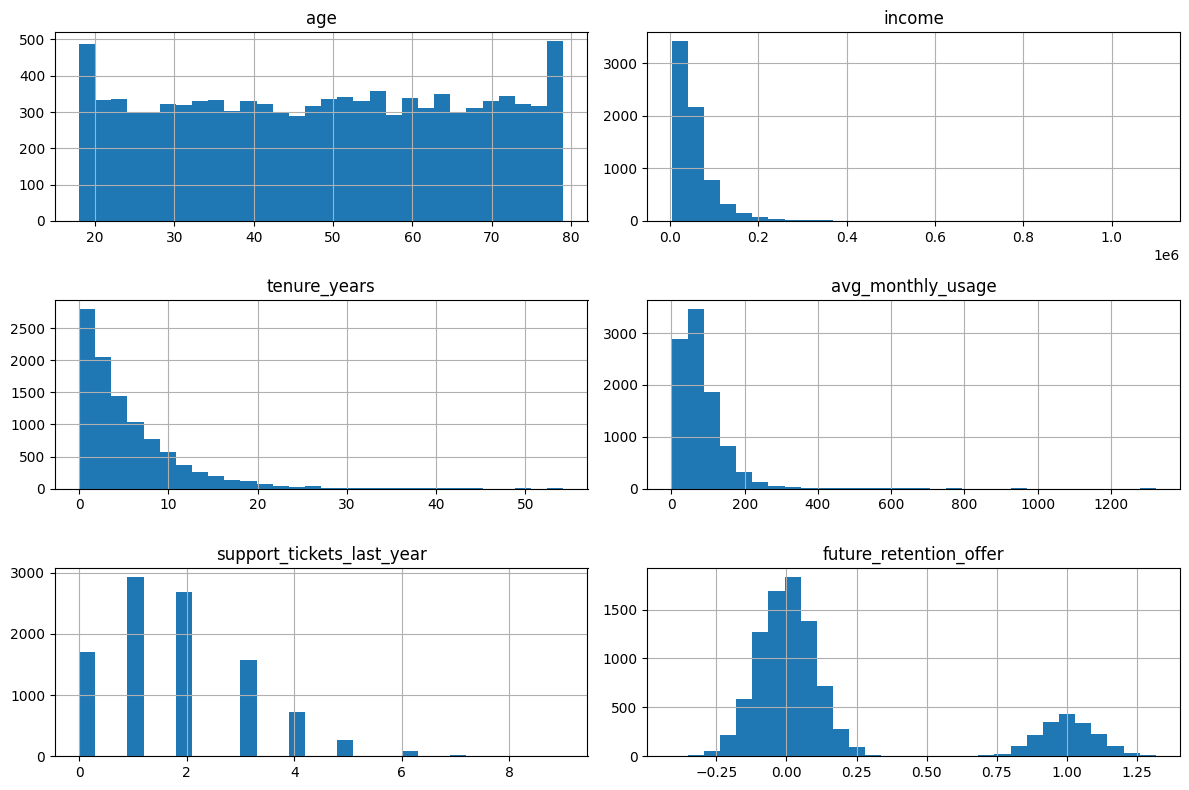

In [5]:
df[numeric_features].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()


### Observations

- Continuous variables show skewness and long tails
- Natural thresholds may exist (e.g. tenure, usage)
- Raw continuous values may be hard to interpret for business users


## Step 3 – Equal-Width Binning

Divides the range into intervals of equal size.

**Pros**
- Simple
- Intuitive

**Cons**
- Sensitive to outliers
- Uneven sample distribution


In [6]:
pd.cut(df["income"], bins=5).value_counts().sort_index()


income
(2228.882, 222672.028]       6903
(222672.028, 442018.442]       82
(442018.442, 661364.857]        9
(661364.857, 880711.271]        1
(880711.271, 1100057.685]       5
Name: count, dtype: int64

## Step 4 – Equal-Frequency (Quantile) Binning

Each bin contains approximately the same number of observations.

**Pros**
- Robust to outliers
- Balanced bins

**Cons**
- Unequal interval widths
- Less intuitive for business interpretation


### Quantile Binning Example

In [7]:
pd.qcut(df["income"], q=5).value_counts().sort_index()


income
(3325.613, 21554.062]       1400
(21554.062, 33427.361]      1400
(33427.361, 49138.143]      1400
(49138.143, 76621.852]      1400
(76621.852, 1100057.685]    1400
Name: count, dtype: int64

## Step 5 – Business-Driven Binning

Bins are defined using domain knowledge rather than statistics.

**Examples**
- Customer tenure bands
- Income brackets
- Usage tiers

This is often the **preferred approach** in production systems.

### Custom Business Bins

In [8]:
tenure_bins = [0, 1, 3, 5, 10, np.inf]
tenure_labels = ["<1y", "1–3y", "3–5y", "5–10y", "10y+"]

df["tenure_band"] = pd.cut(
    df["tenure_years"],
    bins=tenure_bins,
    labels=tenure_labels
)

df["tenure_band"].value_counts()


tenure_band
1–3y     2622
5–10y    2460
3–5y     1758
<1y      1618
10y+     1542
Name: count, dtype: int64

## Step 6 – Supervised Binning (Target-Aware)

Bins are chosen to maximize separation with respect to the target.

 **High leakage risk**  
Must be performed **inside cross-validation only**.
### Target Mean by Quantile

In [12]:
pd.qcut(df["income"], q=5).groupby(pd.qcut(df["income"], q=5)
                                  )["churn"].mean()


C:\Users\pantu\AppData\Local\Temp\ipykernel_4388\994998190.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.qcut(df["income"], q=5).groupby(


KeyError: 'Column not found: churn'

## Step 7 – Discretization with KBinsDiscretizer

Scikit-learn’s pipeline-friendly discretizer.

Supports:
- uniform (equal-width)
- quantile (equal-frequency)
- kmeans (distance-based)

### KBins Example

In [15]:
income_var = df[["income"]].fillna(df[["income"]].median())

In [16]:
kbd = KBinsDiscretizer(
    n_bins=5,
    encode="ordinal",
    strategy="quantile"
)

income_binned = kbd.fit_transform(income_var)
income_binned[:10]


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


array([[2.],
       [2.],
       [1.],
       [2.],
       [0.],
       [2.],
       [1.],
       [0.],
       [2.],
       [1.]])

## Step 8 – Discretization Inside Pipelines (Correct Approach)

Discretization must be:
- Fitted on training data only
- Applied consistently at inference time


In [17]:
discretization_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("binning", KBinsDiscretizer(
        n_bins=5,
        encode="ordinal",
        strategy="quantile"
    ))
])

discretization_pipeline


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('binning', KBinsDiscretizer(encode='ordinal'))])

## Step 9 – When Discretization Helps

Discretization is often beneficial for:
- Linear and logistic regression
- Scorecard models
- Interpretability-focused systems
- Noisy continuous variables

Less useful for:
- Tree-based models
- Neural networks


## Step 10 – Common Mistakes (Avoided)

- `[neg] - ` Arbitrary bin boundaries
- `[neg] - ` Supervised binning outside CV
- `[neg] - ` Over-binning (too many bins)
- `[neg] - ` Assuming bins always improve performance


## Summary Table

| Technique | Use Case |
|---------|----------|
| Equal-width | Simple ranges |
| Quantile | Robust binning |
| Business bins | Production systems |
| Supervised binning | Controlled experiments |
| KBinsDiscretizer | Pipeline-safe discretization |


## Key Takeaways

- Discretization is optional, not mandatory
- Business-driven bins are often superior
- Supervised binning requires strict validation
- Pipelines prevent leakage and inconsistencies


## Next Notebook

02_Data_Preprocessing/

└── [06_data_type_and_schema_management.ipynb](./06_data_type_and_schema_management.ipynb/)
